In [1]:
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')
sys.path.append("/home/xinqiao/m3_learning/m3_learning/src")

In [2]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2 

In [57]:
from m3_learning.viz.printing import printer
from m3_learning.viz.style import set_style
from m3_learning.nn.Bright_Field_NN.Dataset import Bright_Field_Dataset
from m3_learning.nn.Bright_Field_NN.Viz import Viz
from m3_learning.viz.layout import layout_fig, labelfigs

# Specify the filename and the path to save the file
save_path = './../../../Data/2023_Bright_Field'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path)

# Set the style of the plots
set_style("printing")

printing set for seaborn


In [58]:
dset = Bright_Field_Dataset('/home/xinqiao/m3_learning/Data/2023_Bright_Field/Annealed','Annealed_results',verbose=True)

# dset.write_h5(200,300,1400,name='Anneal')

number of images:  43


In [59]:
dset.list_imgs()

['Ramp_Up 23',
 'Ramp_Up 30',
 'Ramp_Up 40',
 'Ramp_Up 50',
 'Ramp_Up 60',
 'Ramp_Up 70',
 'Ramp_Up 80',
 'Ramp_Up 90',
 'Ramp_Up 100',
 'Ramp_Up 110',
 'Ramp_Up 120',
 'Ramp_Up 130',
 'Ramp_Up 140',
 'Ramp_Up 150',
 'Ramp_Up 160',
 'Ramp_Up 170',
 'Ramp_Up 180',
 'Ramp_Up 190',
 'Ramp_Up 200',
 'Ramp_Up 210',
 'Ramp_Up 220',
 'Ramp_Up 250',
 'Ramp_Down 220',
 'Ramp_Down 210',
 'Ramp_Down 200',
 'Ramp_Down 190',
 'Ramp_Down 180',
 'Ramp_Down 170',
 'Ramp_Down 160',
 'Ramp_Down 150',
 'Ramp_Down 140',
 'Ramp_Down 130',
 'Ramp_Down 120',
 'Ramp_Down 110',
 'Ramp_Down 100',
 'Ramp_Down 90',
 'Ramp_Down 80',
 'Ramp_Down 70',
 'Ramp_Down 60',
 'Ramp_Down 50',
 'Ramp_Down 40',
 'Ramp_Down 30',
 'Ramp_Down 20']


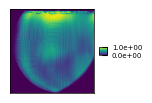

In [60]:
im = dset.get_img('Down',"50")
plt.imshow(im)
plt.show()

In [61]:
type(im)

numpy.ndarray

In [62]:
viz = Viz(dset,printer=printing)

In [63]:
viz.scalebar_ = {"width": 273.4, "scale length": 50, "units": "nm"}

In [64]:
img_name = ['Up','23']
viz.view_raw(img_name)

./../../../Figures/2023_Bright_Field/Up_23_maps.png
./../../../Figures/2023_Bright_Field/Up_23_maps.svg
